In [1]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, concatenate, GlobalAveragePooling2D, Dense, MaxPooling2D,concatenate,DepthwiseConv2D,BatchNormalization,ReLU,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Concatenate
import keras.backend as K
import os
import numpy as np
import shutil
import tensorflow as tf
from tensorflow.keras.metrics import Metric

In [2]:
train_dir = r'F:\MV\Dataset\cars_tanks\train'
test_dir = r'F:\MV\Dataset\cars_tanks\test'

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.15, 
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1.0/255)


In [4]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'  
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation' 
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1108 images belonging to 2 classes.
Found 195 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Flatten, Input, Dense, GlobalAveragePooling2D, Reshape, Multiply
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# #def attention moudle
from tensorflow.keras.layers import Layer
class SelfAttention(Layer):
    def __init__(self, filters):
        super(SelfAttention, self).__init__()
        self.filters = filters

    def build(self, input_shape):
        self.Wq = Dense(self.filters)
        self.Wk = Dense(self.filters)
        self.Wv = Dense(self.filters)
        self.Ws = Dense(1, activation='sigmoid')
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        q = self.Wq(inputs)
        k = self.Wk(inputs)
        v = self.Wv(inputs)

        attention_scores = tf.matmul(q, k, transpose_b=True)
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)

        attended_values = tf.matmul(attention_weights, v)

        # Apply spatial attention weights
        avg_pool = GlobalAveragePooling2D()(attended_values)
        avg_pool = Reshape((1, 1, self.filters))(avg_pool)
        spatial_weights = self.Ws(avg_pool)
        attended_inputs = Multiply()([attended_values, spatial_weights])

        return attended_inputs

import tensorflow as tf
from tensorflow.keras import layers, models

def depthwise_separable_conv(x, filters, kernel_size, strides):
    x = layers.DepthwiseConv2D(kernel_size, strides=strides, padding='same', depth_multiplier=1, activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (1, 1), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def build_mobilenetv2(input_shape, num_classes):
    input_layer = layers.Input(shape=input_shape)

    # Initial Convolution
    x = layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', activation=None)(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Depthwise Separable Convolution Blocks
    x = depthwise_separable_conv(x, 32, (3, 3), (1, 1))
    x = depthwise_separable_conv(x, 64, (3, 3), (2, 2))
    x = depthwise_separable_conv(x, 64, (3, 3), (1, 1))
    x = SelfAttention(32)(x)

    # Middle Flow
    for _ in range(5):
        x = depthwise_separable_conv(x, 32, (3, 3), (1, 1))

    # Exit Flow
    x = depthwise_separable_conv(x, 64, (3, 3), (2, 2))
    x = depthwise_separable_conv(x, 64, (3, 3), (1, 1))

    # Global Average Pooling and Dense Layer
    x = layers.GlobalAveragePooling2D()(x)
    output_layer = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=output_layer)

    return model

# Assuming you have a dataset with input_shape and num_classes defined
# Replace these values accordingly

input_shape = (224, 224, 3)  # Adjust input shape based on your dataset
num_classes = 2  # Adjust based on the number of classes in your dataset

# Build the MobileNetV2 model
mobilenetv2_model = build_mobilenetv2(input_shape, num_classes)


opt = Adam(learning_rate=0.001)

# Compile the model
mobilenetv2_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
mobilenetv2_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 112, 112, 32)      0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 112, 112, 32)     320       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 32)     128   

In [6]:
input_shape = Input(shape=(224,224,3))

In [7]:
from tensorflow.keras.callbacks import EarlyStopping
history=mobilenetv2_model.fit(train_generator, validation_data = validation_generator, epochs=300, 
callbacks=[EarlyStopping(monitor='val_accuracy', patience=60, restore_best_weights = True)])

Epoch 1/300
35/35 [==============================] - 18s 342ms/step - loss: 0.5640 - accuracy: 0.7148 - val_loss: 0.7173 - val_accuracy: 0.4359
Epoch 2/300
35/35 [==============================] - 12s 332ms/step - loss: 0.4536 - accuracy: 0.7933 - val_loss: 0.7693 - val_accuracy: 0.4359
Epoch 3/300
35/35 [==============================] - 12s 328ms/step - loss: 0.4118 - accuracy: 0.8078 - val_loss: 0.8468 - val_accuracy: 0.4359
Epoch 4/300
35/35 [==============================] - 11s 311ms/step - loss: 0.3931 - accuracy: 0.8240 - val_loss: 0.9564 - val_accuracy: 0.4359
Epoch 5/300
35/35 [==============================] - 11s 330ms/step - loss: 0.3810 - accuracy: 0.8475 - val_loss: 1.0820 - val_accuracy: 0.4359
Epoch 6/300
35/35 [==============================] - 11s 310ms/step - loss: 0.3888 - accuracy: 0.8186 - val_loss: 1.1571 - val_accuracy: 0.4359
Epoch 7/300
35/35 [==============================] - 11s 320ms/step - loss: 0.3706 - accuracy: 0.8430 - val_loss: 1.2461 - val_accuracy:

In [8]:
# Print final training and validation accuracy and loss
train_loss, train_acc = mobilenetv2_model.evaluate(train_generator)
val_loss, val_acc = mobilenetv2_model.evaluate(validation_generator)
test_loss, test_acc = mobilenetv2_model.evaluate(test_generator)

print(f"Final Training Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
print(f"Final Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

7/7 [==============================] - 0s 53ms/step - loss: 0.6174 - accuracy: 0.8400
Final Training Loss: 0.1221, Accuracy: 0.9531
Final Validation Loss: 0.1753, Accuracy: 0.9436
Final Test Loss: 0.6174, Accuracy: 0.8400


In [9]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()

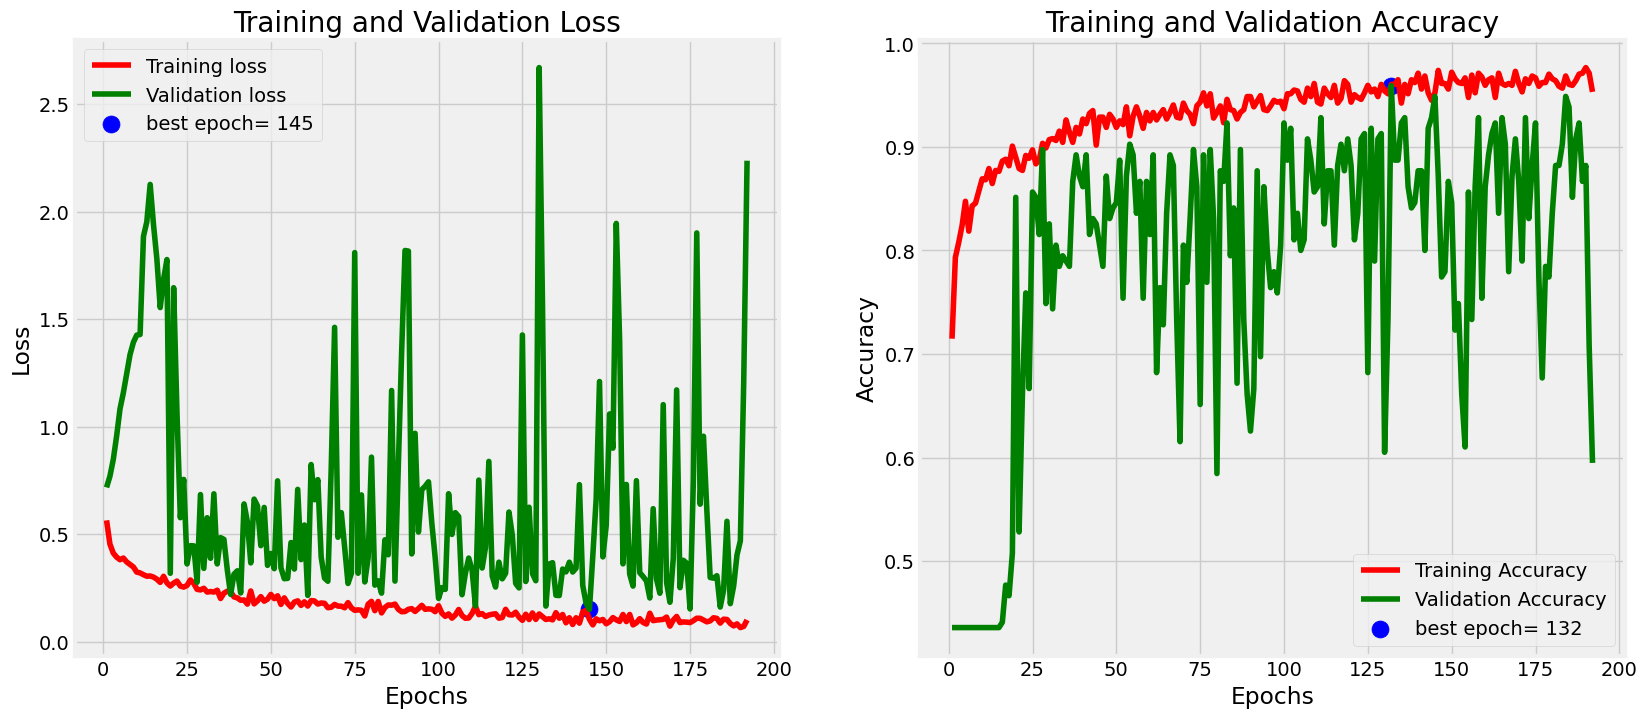

In [10]:
plot_training(history)

In [11]:
# Print final training and validation accuracy and loss
train_loss, train_acc = mobilenetv2_model.evaluate(train_generator)
val_loss, val_acc = mobilenetv2_model.evaluate(validation_generator)

print(f"Final Training Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")



7/7 [==============================] - 2s 227ms/step - loss: 0.2078 - accuracy: 0.9282
Final Training Loss: 0.1217, Accuracy: 0.9540
Final Validation Loss: 0.2078, Accuracy: 0.9282


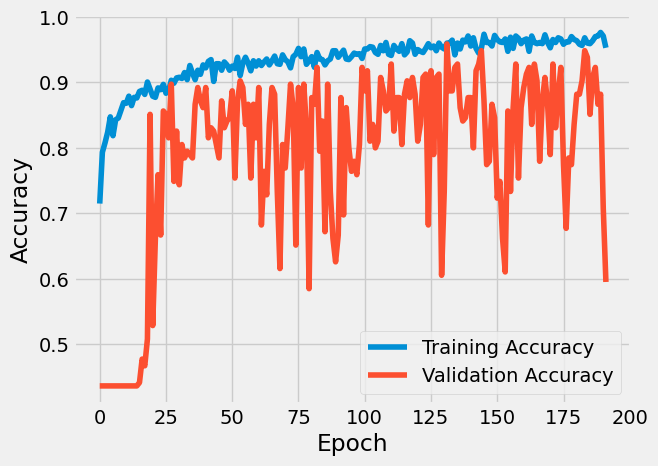

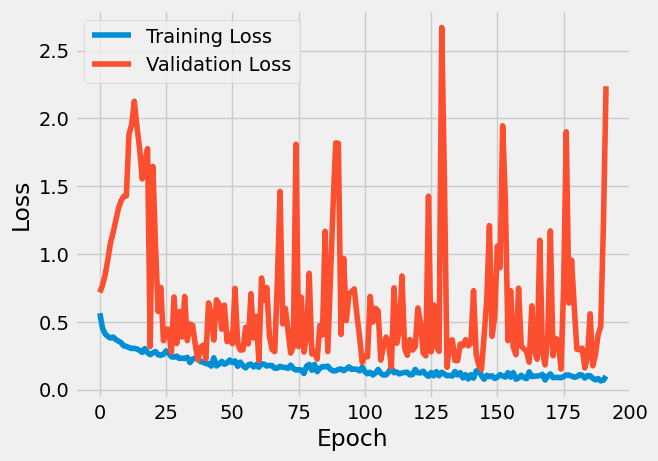

In [12]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
import tensorflow as tf
mobilenetv2_model.save_weights('saved_models\mobileV2_best_weights.h5')

In [14]:
from keras import backend as K
import gc
del model
K.clear_session()
gc.collect()



NameError: name 'model' is not defined